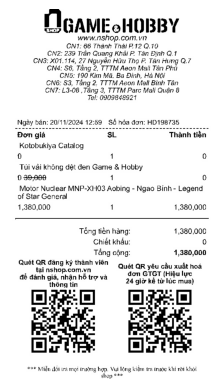

In [3]:
import cv2
from matplotlib import pyplot as plt
from PIL import Image
import json

# Đọc ảnh
img = cv2.imread("./images/BILL_1.jpg")

def show_image(img):
    # Kiểm tra ảnh có được đọc đúng không
    if img is None:
        print("Không tìm thấy ảnh")
    else:
        # Hiển thị ảnh
        plt.imshow(img)
        plt.axis("off")
        plt.show()

show_image(img)

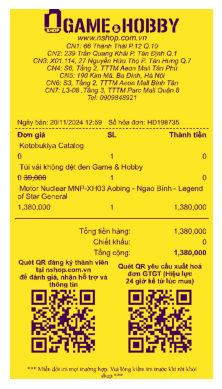

In [ ]:
# import cv2
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


# show_image(gray)

In [5]:
! pip install easyocr --user transformers datasets accelerate torchvision

In [8]:
! pip install --upgrade torch torchvision

   ---------------------------------------- 0.0/216.1 MB ? eta -:--:--
   ---------------------------------------- 0.5/216.1 MB 4.2 MB/s eta 0:00:52
   ---------------------------------------- 1.3/216.1 MB 4.5 MB/s eta 0:00:48
   ---------------------------------------- 2.1/216.1 MB 4.1 MB/s eta 0:00:53
    --------------------------------------- 2.9/216.1 MB 3.8 MB/s eta 0:00:56
    --------------------------------------- 3.4/216.1 MB 3.7 MB/s eta 0:00:58
    --------------------------------------- 4.2/216.1 MB 3.6 MB/s eta 0:00:59
    --------------------------------------- 5.0/216.1 MB 3.6 MB/s eta 0:01:00
   - -------------------------------------- 6.0/216.1 MB 3.8 MB/s eta 0:00:56
   - -------------------------------------- 7.1/216.1 MB 3.9 MB/s eta 0:00:54
   - -------------------------------------- 7.6/216.1 MB 3.8 MB/s eta 0:00:55
   - -------------------------------------- 8.7/216.1 MB 3.9 MB/s eta 0:00:53
   - -------------------------------------- 9.4/216.1 MB 3.9 MB/s eta 0

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
facenet-pytorch 2.6.0 requires torch<2.3.0,>=2.2.0, but you have torch 2.7.1 which is incompatible.
facenet-pytorch 2.6.0 requires torchvision<0.18.0,>=0.17.0, but you have torchvision 0.22.1 which is incompatible.
torchaudio 2.6.0 requires torch==2.6.0, but you have torch 2.7.1 which is incompatible.


   ---------------------------------------- 0/3 [sympy]
   ---------------------------------------- 0/3 [sympy]
   ---------------------------------------- 0/3 [sympy]
   ---------------------------------------- 0/3 [sympy]
   ---------------------------------------- 0/3 [sympy]
   ---------------------------------------- 0/3 [sympy]
   ---------------------------------------- 0/3 [sympy]
   ---------------------------------------- 0/3 [sympy]
   ---------------------------------------- 0/3 [sympy]
   ---------------------------------------- 0/3 [sympy]
   ---------------------------------------- 0/3 [sympy]
   ---------------------------------------- 0/3 [sympy]
   ---------------------------------------- 0/3 [sympy]
   ---------------------------------------- 0/3 [sympy]
   ---------------------------------------- 0/3 [sympy]
   ---------------------------------------- 0/3 [sympy]
   ---------------------------------------- 0/3 [sympy]
   ---------------------------------------- 0/3 

In [6]:
def load_image_and_label(image_path, label_path):
    image = Image.open(image_path).convert("RGB")
    with open(label_path, "r", encoding="utf-8") as f:
        label_data = json.load(f)
    label_text = json.dumps(label_data, ensure_ascii=False)
    return image, label_text


In [9]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

model_name = "naver-clova-ix/donut-base-finetuned-docvqa"
processor = DonutProcessor.from_pretrained(model_name)
model = VisionEncoderDecoderModel.from_pretrained(model_name)


ValueError: Due to a serious vulnerability issue in `torch.load`, even with `weights_only=True`, we now require users to upgrade torch to at least v2.6 in order to use the function. This version restriction does not apply when loading files with safetensors.
See the vulnerability report here https://nvd.nist.gov/vuln/detail/CVE-2025-32434